In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.spatial.distance import cdist

In [2]:
from matplotlib import pyplot as plt


def augmentX(X):
    n = X.shape[0]
    return np.concatenate((np.ones((n, 1)), X),  axis=1)


def unAugmentX(X):
    # Assume the first dimension has all ones
    return X[:, 1:]


def convertToOneHot(y, n_classes):
    # y should be a 1d array
    y = y.astype(int).flatten()
    Y = np.eye(n_classes)[y]
    return Y.astype(float)


def generateData(n, gen_model, rand_seed=None):

    d = 2
    shift = 1.8

    if rand_seed is not None:
        np.random.seed(rand_seed)

    X = []
    y = []
    m = n // 4
    class_label = 0
    for i in [-1, 1]:
        for j in [-1, 1]:
            if gen_model == 1:
                X.append(np.random.randn(m, d) + 
                         class_label * shift)
            elif gen_model == 2:
                X.append(np.random.randn(m, d) + 
                         shift * np.array([[i, j]]))
            else:
                raise ValueError("Unknown generative model")
            y.append(np.ones((m, 1)) * class_label)
            class_label += 1
    X = np.vstack(X)
    y = np.vstack(y)

    return X, convertToOneHot(y, 4)


def plotPoints(X, Y):
    # plot the data points
    k = Y.shape[1]
    markers = ['o', '+', 'd', 'x', '^', 'v', 's']
    colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
    labels = Y.argmax(axis=1)
    for i in range(k):
        Xpart = X[labels == i]

        plt.scatter(Xpart[:, 0], Xpart[:, 1], 
                    marker=markers[i], 
                    color=colors[i],
                    label=f'class {i}')
    return


def getRange(X):
    x_min = np.amin(X[:, 0]) - 0.1
    x_max = np.amax(X[:, 0]) + 0.1
    y_min = np.amin(X[:, 1]) - 0.1
    y_max = np.amax(X[:, 1]) + 0.1
    return x_min, x_max, y_min, y_max


def plotModel(X, Y, W, classify):

    X = unAugmentX(X)
    plotPoints(X, Y)

    # plot model
    x_min, x_max, y_min, y_max = getRange(X)
    grid_step = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    Y = classify(np.c_[np.ones(len(xx.ravel())), xx.ravel(), yy.ravel()], W)
    labels = Y.argmax(axis=1)

    # Put the result into a color plot
    labels = labels.reshape(xx.shape)
    plt.contourf(xx, yy, labels, 
                 colors=['r', 'r', 'b', 'b', 'g', 'g', 'y', 'y'], 
                 alpha=0.3)
    plt.legend()
    plt.show()
    return


def synClsExperiments(minMulDev, classify, calculateAcc):
    n_runs = 10
    n_test = 1000
    n_train_list = [16, 32, 64, 128]
    gen_model_list = [1, 2]
    train_acc = np.zeros([len(n_train_list), len(gen_model_list), n_runs])
    test_acc = np.zeros([len(n_train_list), len(gen_model_list), n_runs])
    for r in range(n_runs):
        for i, n_train in enumerate(n_train_list):
            for j, gen_model in enumerate(gen_model_list):
                Xtrain, Ytrain = generateData(n=n_train, gen_model=gen_model)
                Xtest, Ytest = generateData(n=n_test, gen_model=gen_model)
                
                Xtrain = augmentX(Xtrain)
                Xtest = augmentX(Xtest)

                W = minMulDev(Xtrain, Ytrain)
                Yhat = classify(Xtrain, W)
                train_acc[i, j, r] = calculateAcc(Yhat, Ytrain)
                Yhat = classify(Xtest, W)
                test_acc[i, j, r] = calculateAcc(Yhat, Ytest)

    train_acc = np.mean(train_acc, axis=2)
    test_acc = np.mean(test_acc, axis=2)
    
    return train_acc, test_acc


def plotImg(x):
    img = x.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()
    return


def plotImgs(X):
    # plot the first 20 images of X
    fig = plt.figure(figsize=(16, 6))
    for i in range(20):
        ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(X[i].reshape((28, 28)), cmap='gray')
    plt.show()
    return




def _plotKmeans():

	n = 300
	k = 5

	Xtrain, _ = generateData(n, gen_model=2)

	Y, U, obj_val = kmeans(Xtrain, k)
	plotPoints(Xtrain, Y)
	plt.legend()
	plt.show()

	return

In [3]:
#Q3a

def kmeans(X,k,max_iter=1000):
    if(max_iter <= 0):
        return False
     
    n,d = X.shape
    U = X[np.random.choice(n,k,replace=False)]

    for i in range(max_iter):

        D = cdist(X, U, 'euclidean')
        Y = np.argmin(D, axis=1)

        old_U = U
        Y = convertToOneHot(Y, k)
        YtY = Y.T @ Y + 1e-8 * np.eye(k) #for stability
        U = np.linalg.inv(YtY) @ Y.T @ X

        if np.allclose(U, old_U):
            break

        
    obj_val = 1/(2*n) * np.linalg.norm(X - Y @ U, 'fro')**2

    return Y, U, obj_val


  


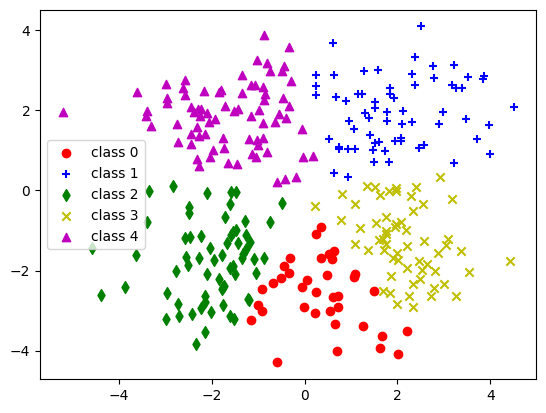

In [4]:
_plotKmeans()

In [5]:
#Q3b

def repeatKmeans(X,k,n_runs=100):
    best_obj_val = float('inf')

    bestY, bestU = None,None

    for r in range(n_runs):
        Y, U, obj_val = kmeans(X,k)

        if obj_val < best_obj_val:
            best_obj_val = obj_val
            bestY, bestU = Y,U

    return bestY, bestU, best_obj_val



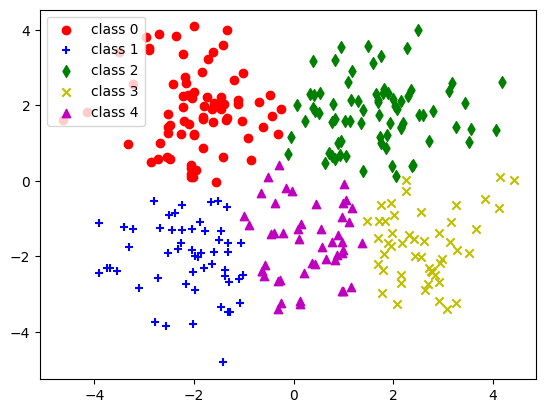

In [6]:
def _plotKmeans2():

	n = 300
	k = 5

	Xtrain, _ = generateData(n, gen_model=2)

	Y, U, obj_val = repeatKmeans(Xtrain, k)
	plotPoints(Xtrain, Y)
	plt.legend()
	plt.show()

	return


_plotKmeans2()